In [93]:
import sys

sys.path.append('..')

In [94]:
import os


os.environ["DATA_DIR"] = "../data"
os.environ["TRAIN_DIR"] = "../data/test_images"
os.environ["TEST_DIR"] = "../data/test_images"
os.environ["MODELS_DIR"] = "../models"
os.environ["RESULTS_DIR"] = "../results"

import torch
from src.config import config
from src.device import get_device
from src.net import Net
from src.data import transform
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [95]:
device = get_device()

In [96]:
net = Net()
net.load_state_dict(torch.load(config.models_dir / "model_2024-12-05_11-33-59" / "model.pth", weights_only=False))
# net.load_state_dict(torch.load(config.models_dir / "model_2025-01-07_09-45-42" / "model.pth", weights_only=False))
net.to(device)

net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

In [97]:
# src_path = config.data_dir / "false_positives_sources" / "clothes2.jpg"
src_path = config.data_dir / "people4.jpeg"
img = Image.open(src_path)

In [98]:
from src.reinforcement.scale_sliding_image_dataset import ScaleSlidingImagesDataset


window_size = 32
stride = 4

found: list[tuple[float, float, float, float]] = []

dataset = ScaleSlidingImagesDataset(
    [src_path],
    transform=transform,
    window_size=window_size,
    stride=stride,
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
)

with torch.no_grad():
    for data in dataloader:
        data, meta = data
        data = data.to(device)

        outputs = net(data)
        _, predicted = torch.max(outputs, 1)
        confidences = torch.nn.functional.softmax(outputs, dim=1)
        
        for prediction, confidence, scale, x, y, idx in zip(
                predicted, confidences, meta["scale"], meta["x"], meta["y"], meta["idx"]
            ):
                if prediction != 1:
                    continue

                _, confidence = confidence

                found.append((scale, x, y, confidence))

In [99]:
scaled_boxes: list[tuple[float, float, float, float, float]] = []

for scale, x, y, confidence in found:
    scaled_boxes.append((x * scale, y * scale, (x + window_size) * scale, (y + window_size) * scale, confidence))

In [100]:
scaled_boxes

[(tensor(512),
  tensor(96),
  tensor(768),
  tensor(352),
  tensor(0.6449, device='mps:0')),
 (tensor(288),
  tensor(128),
  tensor(544),
  tensor(384),
  tensor(0.9998, device='mps:0')),
 (tensor(224),
  tensor(56),
  tensor(448),
  tensor(280),
  tensor(0.6653, device='mps:0')),
 (tensor(280),
  tensor(112),
  tensor(504),
  tensor(336),
  tensor(0.8044, device='mps:0')),
 (tensor(72),
  tensor(24),
  tensor(264),
  tensor(216),
  tensor(0.5806, device='mps:0')),
 (tensor(96),
  tensor(48),
  tensor(288),
  tensor(240),
  tensor(0.7331, device='mps:0')),
 (tensor(120),
  tensor(48),
  tensor(312),
  tensor(240),
  tensor(0.9031, device='mps:0')),
 (tensor(576),
  tensor(96),
  tensor(768),
  tensor(288),
  tensor(0.8165, device='mps:0')),
 (tensor(504),
  tensor(120),
  tensor(696),
  tensor(312),
  tensor(0.6800, device='mps:0')),
 (tensor(528),
  tensor(120),
  tensor(720),
  tensor(312),
  tensor(0.7038, device='mps:0')),
 (tensor(552),
  tensor(120),
  tensor(744),
  tensor(312)

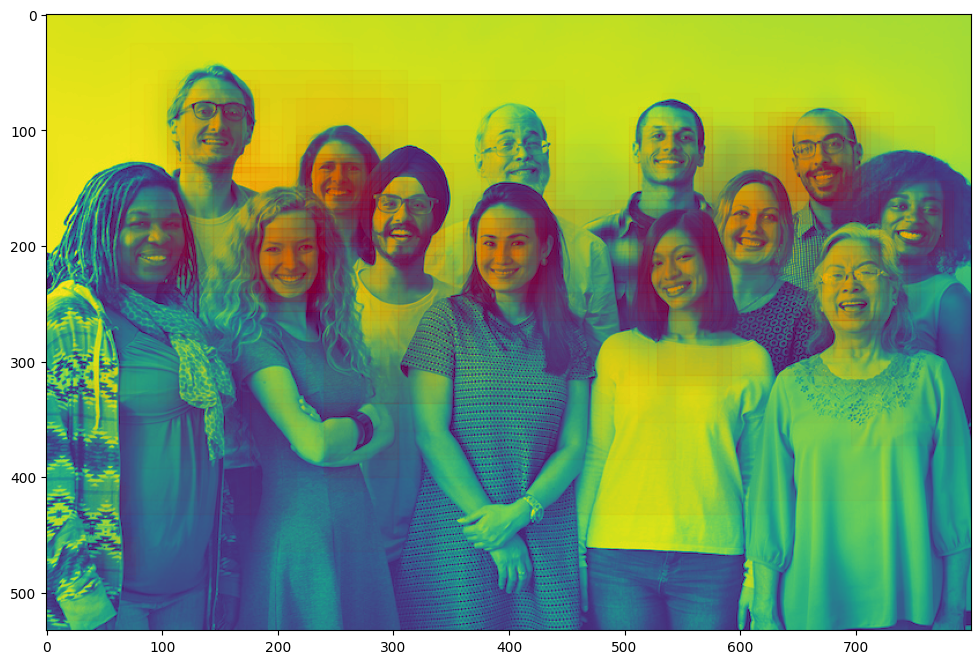

In [101]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img.convert("L"))

for xmin, ymin, xmax, ymax, confidence in scaled_boxes:
    rect = patches.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        color='#FF0000' + hex(int(confidence * 6))[2:].zfill(2),
    )
    
    ax.add_patch(rect)

plt.show()

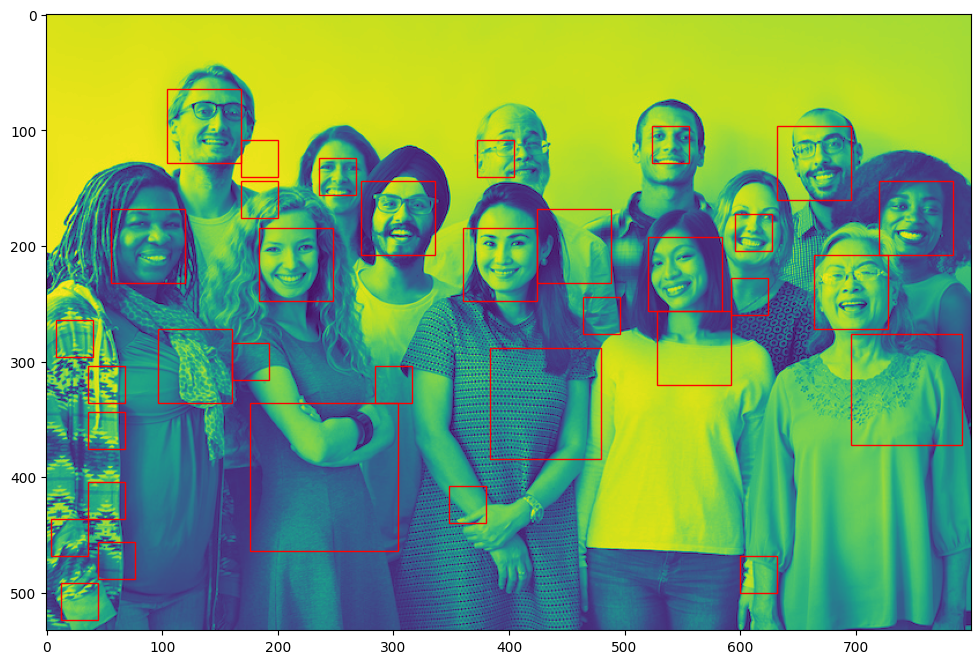

In [102]:
def calculate_iou(box1: list, box2: list) -> float:
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1 (list): The first bounding box in the format [xmin, ymin, xmax, ymax].
        box2 (list): The second bounding box in the format [xmin, ymin, xmax, ymax].

    Returns:
        float: The IoU of the two bounding boxes.
    """
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2

    xi1 = max(x1, x3)
    yi1 = max(y1, y3)
    xi2 = min(x2, x4)
    yi2 = min(y2, y4)

    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x4 - x3) * (y4 - y3)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area != 0 else 0


def non_max_suppression(boxes: list, 
                        scores: list, 
                        iou_threshold: float) -> tuple[list, list]:
    """
    Perform non-max suppression on a set of bounding boxes and corresponding scores.

    Args:
        boxes (list): A list of bounding boxes in the format [[xmin, ymin, xmax, ymax], ...].
        scores (list): A list of corresponding scores.
        iou_threshold (float): The IoU (Intersection over Union) threshold for merging bounding boxes.

    Returns:
       list: A list of indices of the boxes to keep after non-max suppression.
    """
    num_boxes = len(boxes)
    order = sorted(range(num_boxes), key=lambda i: scores[i], reverse=True)
    selected_indices = []
    summed_confidences = []

    while order:
        i = order.pop(0)
        selected_indices.append(i)
        sum_confidence = scores[i]
        to_remove = []
        for j in order:
            if calculate_iou(boxes[i], boxes[j]) > iou_threshold:
                sum_confidence += scores[j]
                to_remove.append(j)
        order = [j for j in order if j not in to_remove]
        summed_confidences.append(sum_confidence)

    return selected_indices, summed_confidences

scaled_boxes_index = non_max_suppression(
    [(xmin, ymin, xmax, ymax) for xmin, ymin, xmax, ymax, _ in scaled_boxes],
    [confidence for _, _, _, _, confidence in scaled_boxes],
    1e-99,
)

fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img.convert("L"))

for i, box_confidence in zip(scaled_boxes_index[0], scaled_boxes_index[1]):
    xmin, ymin, xmax, ymax, confidence = scaled_boxes[i]
    
    rect = patches.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=1,
        edgecolor='r',
        facecolor='none',
        # color='#FF0000' + hex(int(min(255, box_confidence * 5)))[2:].zfill(2),
    )
    
    ax.add_patch(rect)

plt.show()